# Lazy Sequences

## Lazy VS. Eager Evaluation

* **Evaluation** turns expressions into values,
* **Eager** evaluation $\longrightarrow$ performed ASAP,
* **Lazy** evaluation $\longrightarrow$ delays evaluation as long as possible.

### Example - Most comprehensions are eager

**Note.** You can tell an operation is eager if you see the data on evaluation.

#### `list` comprehensions are eager

In [1]:
[x**2 for x in range(1,11)]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

#### `dict` comprehensions are eager

In [2]:
{x:x**2 for x in range(1,11)}

{1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81, 10: 100}

#### `set` comprehensions are eager

In [3]:
{ch for ch in 'aaaaddcasdasdfccss'}

{'a', 'c', 'd', 'f', 's'}

### Generator expressions are lazy

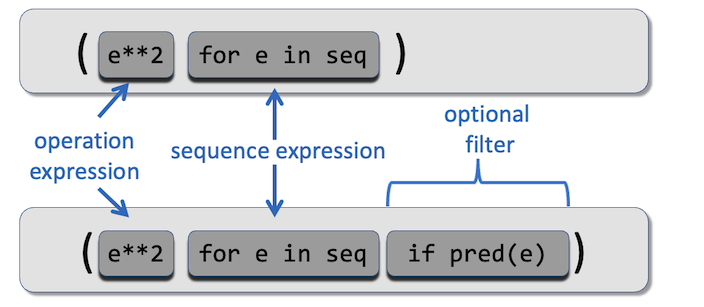

In [4]:
(sqrs := 
 (i**2 for i in range(10000))
)

<generator object <genexpr> at 0x118885220>

In [5]:
(doubled := 
 (2*i for i in sqrs)
)  

<generator object <genexpr> at 0x118884e10>

In [6]:
(plus_2 := 
 (i + 2 for i in doubled)
)

<generator object <genexpr> at 0x118884fb0>

### Other lazy constructs in python

#### `range`

In [7]:
range(1000000000)

range(0, 1000000000)

#### The built-in `map`, `filter`, `enumerate`, and `zip`

In [23]:
(lazy_map :=
map(lambda x: x**2, range(1000000000))
)

In [24]:
(lazy_filter :=
filter(lambda x: x <= 100, range(1000000000))
)

In [25]:
enumerate(lazy_filter)

In [26]:
zip(lazy_map, lazy_filter)

### Various functions from the standard `itertools` library

In [28]:
from itertools import chain

In [29]:
chain(lazy_map, lazy_filter)

#### Lazy constructs from other modules like `toolz`

In [6]:
from toolz import pipe
from toolz.curried import map, filter, take, curry, take
from toolz.curried.operator import add, pow

pipe(range(10000000),               # lazy  
     filter(lambda n: n % 5 == 0),  # lazy   
     map(add(2)),                   # lazy  
     take(10))                      # lazy    

## Forcing evaluation

To force evaluation of a lazy construct, we need to apply some eager construct. Here are some examples.

#### Processing in an eager comprehension

In [13]:
[x**2 for x in range(10)]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [14]:
{x:x**2 for x in range(10)}

{0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81}

#### Casting as another data structure like `list`/`dict`/etc.

In [15]:
list(map(lambda x: x**2, range(10)))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

#### Using the eager (strict) versions of `map` and `filter`

In [46]:
import composable.strict as eager

In [47]:
eager.map(lambda x: x**2, range(10))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [48]:
eager.filter(lambda x: x <= 10, range(1000))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Create/import eager tools for `take`/`collect`/`reduce`

In [42]:
eager_take = curry(lambda k, seq: [val for i, val in enumerate(seq) if i < k])

pipe(range(10000000),               # lazy  
     filter(lambda n: n % 5 == 0),  # lazy   
     map(add(2)),                   # lazy    
     eager_take(10))                # eager  

[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]

In [9]:
pipe(range(10000000),               # lazy  
     filter(lambda n: n % 5 == 0),  # lazy   
     map(add(2)),                   # lazy    
     list)[:10]                       # eager  


[2, 7, 12, 17, 22, 27, 32, 37, 42, 47]

In [10]:
from composable.sequence import reduce

pipe(range(10000000),               # lazy  
     filter(lambda n: n % 5 == 0),  # lazy   
     map(add(2)),                   # lazy    
     reduce(add))                   # eager  

9999999000000

## Why do we care?

#### Upsides
* *Eager* evaluation $\longrightarrow$ less overhead and less annoying to use.
* *Lazy* evaluation $\longrightarrow$ easier to distribute and can have less memory pressure.

#### Downsides
* *Eager* evaluation $\longrightarrow$ more memory pressure
* *Lazy* evaluation $\longrightarrow$ more overhead and annoying to use.
* **Python specific** *Lazy* evaluation $\longrightarrow$ can only happen once.

### Example - Adding a LOT of number

Let's compare using a `list` comprehension and `generator` expression to add a large set of numbers.

In [32]:
%%time
sum([x for x in range(1000000000)]) # adds more memory pressure as N grows.

CPU times: user 28.9 s, sys: 3.51 s, total: 32.4 s
Wall time: 32.6 s


499999999500000000

In [33]:
%%time
sum(range(1000000000)) # less memory pressure as we don't need to hold all numbers in memory, BUT ...

CPU times: user 8.45 s, sys: 23.7 ms, total: 8.48 s
Wall time: 8.47 s


499999999500000000

In [34]:
%%time
sum(x for x in range(1000000000)) # adding another layer of generator adds overhead (and loses some of the advantage).

CPU times: user 24.3 s, sys: 11.5 ms, total: 24.3 s
Wall time: 24.3 s


499999999500000000

## Python specific quirks

Unlike other languages (e.g., Haskell), generator in Python can only be processed once.

In [69]:
(sqrs :=
  (x**2 for x in range(10))
)

<generator object <genexpr> at 0xc6709d8a0>

In [70]:
# First time processing "eats" the sequence
list(sqrs)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [73]:
# Subsequent evaluation is empty ..
[x for x in sqrs]

[]

In [75]:
# ... or can raise an exception
next(sqrs)

StopIteration: 

### To reuse a generator, you need to re-initialize it :(

In [77]:
(sqrs :=
  (x**2 for x in range(10))
)

<generator object <genexpr> at 0xc6709f1d0>

In [78]:
# First time processing "eats" the sequence
list(sqrs)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [47]:
# Re-initialize
(sqrs :=
  (x**2 for x in range(10))
)

<generator object <genexpr> at 0x13a71b9f0>

In [48]:
# Subsequent evaluation is empty ..
[x for i, x in enumerate(sqrs) if i < 3]

[0, 1, 4]

## <font color="red"> Exercise 4.0.1 </font>

**Problem.** We want to find the first 5 perfect squares that end in 6.
**Strategy.** Since we don't know how far we need to go, we will use generators to reduce memory load.
**Process.** Use the lazy constructs outlined above to...
1. Generate a large lazy sequence of integers (`range`),
2. Square each integer in the last sequence (lazy `map`),
3. Use a filter to decide if the number ends in 3 (lazy `filter`; **Hint.** convert to a string and inspect the last character), and
4. Take the first five outcomes.

In [76]:
## Your code here

## Appendix - More on Python generators

**Note.** While it is possible to create custom generators as shown below, in most cases it is better to find an established tool from `itertools`/`more_itertools`/`toolz`

### Creating a generator using `yield` and/or `yield from`

* `yield` is the lazy variant of return 
* `yield from seq` will yield each element of `seq` on at a time.

In [9]:
def my_gen(seq):
    yield "hi"
    yield "I am about to do some work"
    yield "Wait for it"
    yield from seq
    yield "Wow! That was too much work!"
g = my_gen(range(3))

### Using `next` to get the next value in the sequence

In [48]:
next(g)

'hi'

In [49]:
next(g)

'I am about to do some work'

In [50]:
next(g)

'Wait for it'

#### Now we `yield from range(3)`

In [41]:
next(g)

0

In [42]:
next(g)

1

In [43]:
next(g)

2

#### `yield from` is complete, now the last `yield`

In [44]:
next(g)

'Wow! That was too much work!'

#### `g` is now empty, another call to `next` causes an exception

In [45]:
next(g)

StopIteration: 